# Análisis de Grandes Volúmenes de Datos
## Actividad 5 | Actividad de visualización de resultados

Estudiantes:
+ Jorge Barón Bracho - A01422588
+ Elda Cristina Morales Sánchez de la Barquera - A00449074
+ Eduardo Selim Martínez Mayorga - A01795167
+ José Arturo Valdivia Rivera - A01795395

In [1]:
#Descargamos las librerias necesarias, iniciamos sesion de Pyspark y cargamos la base de datos
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import countDistinct, count, isnan, when, desc, concat_ws, monotonically_increasing_id, row_number
from pyspark.sql.window import Window
from pyspark.sql.functions import col, expr, mean, stddev, min, max, length, ceil, floor
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, NumericType, IntegerType
from pyspark.ml.feature import Imputer, VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spark = SparkSession.builder.appName("CSVRead").getOrCreate()
df = spark.read.csv("Iowa_Liquor_Sales.csv", header=True, inferSchema=True)

25/06/17 18:08:56 WARN Utils: Your hostname, MacBook-Air-de-Eduardo.local resolves to a loopback address: 127.0.0.1; using 192.168.0.19 instead (on interface en0)
25/06/17 18:08:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/17 18:08:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/17 18:09:11 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
# Cambiamos los nombres de las columnas para facilitar su manejo al programar
df = df.withColumnsRenamed({"Invoice/Item Number": "invoice_number",
"Date": "date",
"Store Number": "store_number",
"Store Name": "store_name",
"Address": "address",
"City": "city",
"Zip Code": "zip_code",
"Store Location": "store_location",
"County Number": "county_number",
"County": "county",
"Category": "category",
"Category Name": "category_name",
"Vendor Number": "vendor_number",
"Vendor Name": "vendor_name",
"Item Number": "item_number",
"Item Description": "item_description",
"Pack": "pack",
"Bottle Volume (ml)": "bottle_volume",
"State Bottle Cost": "bottle_cost",
"State Bottle Retail": "bottle_retail",
"Bottles Sold": "bottles_sold",
"Sale (Dollars)": "sale_dollars",
"Volume Sold (Liters)": "liters_sold",
"Volume Sold (Gallons)": "gallons_sold"})

## Parte 1: Selección de los datos
En esta parte se utilizará una variación de la rutina de las actividades pasadas para construir un subconjunto de trabajo del dataset original (2 millones de datos aproximadamente) utilizando el criterio de estratificación basado en la categoría del producto (`category`) y el vendedor del producto (`vendor_number`).

In [4]:
# Variables de caracterización
vars_caracterizacion = ["category","vendor_number"]

# Total de filas para calcular proporciones
total = df.count()

# Agrupar por combinaciones y contar ocurrencias
df_grouped = df.groupBy(vars_caracterizacion).agg(count("*").alias("conteo"))

# Calcular probabilidad de cada combinación
df_prob = df_grouped.withColumn("probabilidad", col("conteo") / total)

# Conteo nos dice cuantas veces se repite una combinacion
# Probabilidad indica la probabilidad que hay de que salga dicha combinación
# Mostrar ejemplo de combinaciones y sus probabilidades
df_prob = df_prob.orderBy(desc("probabilidad"))

# Creamos la etiqueta del estrato concatenando el número de categoría y el número de vendedor con un guion de por medio
df_estrato = df_prob.select(concat_ws('_',df_prob.category,df_prob.vendor_number).alias("estrato"),
                            "category", "vendor_number", "conteo", "probabilidad")

# Creamos la etiqueta del estrato en el dataset completo
# concatenando el número de categoría y el número de vendedor con un guion de por medio
df = df.withColumn("estrato", concat_ws('_',df.category,df.vendor_number))

# Se define la proporción de la población que se requiere muestrear
prop_poblacion = 0.01

# Se obtiene el tamaño total de la muestra
n = math.ceil(total*prop_poblacion)

# Se obtiene una columna con el tamaño de muestra requerido de cada estrato
df_estrato = df_estrato.withColumn("muestra", col("probabilidad") * n)
df_estrato = df_estrato.withColumn("tamanio_muestra", ceil("muestra"))
df_estrato = df_estrato.withColumn("proporcion_estrato", col("tamanio_muestra")/col("conteo"))

# Se convierte el spark DataFrame en Pandas dataframe para extraer la proporción por estratos a muestrear
pandas_estratos = df_estrato.toPandas()

# Se construye un diccionario con la proporción a muestrear requerida en cada estrato
proporciones = pandas_estratos.set_index('estrato')['proporcion_estrato'].to_dict()

# RESULTADO FINAL
# Se obtiene la muestra por cada estrato del tamaño adecuado
dataset_trabajo = df.sampleBy(col = "estrato", fractions = proporciones, seed = 5)
# Le generamos un id a cada observación (renglón)
dataset_trabajo = dataset_trabajo.withColumn('id', monotonically_increasing_id())

# Se obtiene el tamaño total del dataset
n_dataset = dataset_trabajo.count()

Adicionalmente, se seleccionará como variable objetivo para aprendizaje supervisado al precio del producto (`sale_dolars`) y como variables explicativas al volumen de la botella (`bottle_volumen`), el costo de la botella (`bottle_cost`), el número de botellas vendidas (`bottles_sold`), litros vendidos (`liters_sold) como numéricas y a la categoría del producto (category) y tipo de empaque (pack) como categóricas

In [5]:
variable_objetivo = "sale_dollars"
explicativas_numericas = ["bottle_volume", "bottle_cost", "bottles_sold", "liters_sold"]
explicativas_categoricas = ["category", "pack"]

## Parte 2: Preparación de los datos

En esta sección se completarán valores faltantes, tanto para variables numéricas como para categóricas. Además, las variables categóricas se codificación (one-hot-encoding) para que se pueden utilizar en el modelo de aprendizaje supervisado. También, se escalarán/estandarizarán/normalizará las variables numéricas para tener estabilidad en los algoritmos tanto de aprendizaje supervisado como en los de no supervisado.

In [6]:
# Corrección de datos faltantes para variables categóricas
## Se calcula la moda para las varaibles categóricas
mode_category1 = dataset_trabajo.groupBy("category").agg(count("*").alias("count")).orderBy(col("count").desc()).first()["category"]
mode_category2 = dataset_trabajo.groupBy("pack").agg(count("*").alias("count")).orderBy(col("count").desc()).first()["pack"]

## Se completan los datos faltantes de las variables categóricas con las modas
dataset_trabajo = dataset_trabajo.withColumn("category", when(col("category").isNull(), mode_category1).otherwise(col("category")))
dataset_trabajo = dataset_trabajo.withColumn("pack", when(col("pack").isNull(), mode_category2).otherwise(col("pack")))

# Se completan los datos numéricos faltantes
imputer = Imputer(inputCols = explicativas_numericas,
                  outputCols = explicativas_numericas)

imputer = imputer.fit(dataset_trabajo)

dataset_trabajo = imputer.transform(dataset_trabajo)

# Generamos el objeto con las variables explicativas numéricas
vector_assembler_numerico = VectorAssembler(inputCols = explicativas_numericas,
                                            outputCol = 'explicativas_numericas_vector')

dataset_trabajo = vector_assembler_numerico.transform(dataset_trabajo)

# A las varibles categóricas primero las representaremos mediante un índice único y posteriormente se le aplicará one-hot encoding

## Se representa a las categorías de las variables categóricas como índices únicos
indexers = [
    StringIndexer(inputCol = c, outputCol = "{0}_index".format(c))
    for c in explicativas_categoricas
]

## Se aplica one-hot encoding a cada una de las variables categóricas
encoders = [
    OneHotEncoder(
        inputCol = indexer.getOutputCol(),
        outputCol = "{0}_encoded".format(indexer.getOutputCol())) 
    for indexer in indexers
]

## Generamos el objeto con las variables explicativas categóricas
assembler = VectorAssembler(
    inputCols=[encoder.getOutputCol() for encoder in encoders],
    outputCol = "explicativas_categoricas_vector"
)

pipeline = Pipeline(stages = indexers + encoders + [assembler])
pipeline = pipeline.fit(dataset_trabajo)

dataset_trabajo = pipeline.transform(dataset_trabajo)

# Estandarizamos las variables numéricas para quitar el efecto de la escala de las variables originales
scaler = StandardScaler(inputCol = 'explicativas_numericas_vector',
                        outputCol= 'explicativas_numericas_vector_escaladas',
                        withStd=True, withMean=True)

scaler = scaler.fit(dataset_trabajo)
dataset_trabajo = scaler.transform(dataset_trabajo)

# Juntamos las variables explicativas categóricas como las varables explicativas numéricas
assembler = VectorAssembler(inputCols = ['explicativas_numericas_vector_escaladas', 'explicativas_categoricas_vector'],
                            outputCol = 'explicativas_final_vector')

dataset_trabajo = assembler.transform(dataset_trabajo)

Ahora se clusterizarán las observaciones a partir del algoritmo $K$-means. En las entregas pasadas, se estableció que el número óptimo de clústers es 4

In [7]:
# Seleccionamos como número de cluster óptimo al 5 y se vuelve a ejecutar el algoritmo k-means
kmeans = KMeans(featuresCol = 'explicativas_numericas_vector_escaladas', k = 4)
modelo = kmeans.fit(dataset_trabajo)
dataset_trabajo = modelo.transform(dataset_trabajo)

# Finalmente, se obtienene los centroides de cada clúster
centros = modelo.clusterCenters()
print("Centros de los clústers: ")
for centro in centros:
    print(centro)

25/06/17 18:22:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/06/17 18:22:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Centros de los clústers: 
[-0.19027639  0.12352158 -0.07225402 -0.05518824]
[ 1.75610626  0.22067563 -0.06284748  0.15099303]
[ 1.01591577  0.11294761 21.82619577 22.87033775]
[-1.13117173 -0.55298221  0.16834143 -0.08543359]


Ahora, se verá cuántas observaciones de cada clúster se necesitan para tener significancia en una muestra de entrenamiento

In [8]:
# Renombramos la columna de la predicción del clúster por comodidad
dataset_trabajo = dataset_trabajo.withColumnsRenamed({"prediction": "cluster"})

# Contar el tamaño de los clusters en el dataset de trabajo
df_tamanio_clusters = dataset_trabajo.groupBy("cluster").agg(count("*").alias("conteo"))
df_tamanio_clusters = df_tamanio_clusters.withColumn("probabilidad", col("conteo") / n_dataset)
df_tamanio_clusters = df_tamanio_clusters.orderBy(desc("probabilidad"))

df_temp = df_tamanio_clusters.toPandas()

df_temp['tamanio_ent'] = 0.85*df_temp['conteo']
df_aux = df_temp[df_temp['conteo']>=100]
n_train = math.floor(df_aux['tamanio_ent'].sum())

df_tamanio_clusters = df_tamanio_clusters.withColumn("muestra", col("probabilidad") * n_train)
df_tamanio_clusters = df_tamanio_clusters.withColumn("tamanio_muestra", ceil("muestra"))
df_tamanio_clusters = df_tamanio_clusters.withColumn("proporcion_cluster", col("tamanio_muestra")/col("conteo"))
df_tamanio_clusters = df_tamanio_clusters.orderBy(desc("proporcion_cluster"))

# Se convierte el spark DataFrame en Pandas dataframe para extraer la proporción por estratos a muestrear
pd_clusters_trabajo = df_tamanio_clusters.toPandas()
df_proporciones = pd_clusters_trabajo
df_proporciones['fold_restante'] = np.floor(0.1 * pd_clusters_trabajo['conteo'])

Entonces para que cada la muestra sea suficientemente signigicativa en cada clúster debe tener los siguientes tamaños (proporciones)

In [9]:
df_proporciones

,cluster,conteo,probabilidad,muestra,tamanio_muestra,proporcion_cluster,fold_restante
0,2,235,0.000894,199.749151,200,0.851064,23.0
1,1,52416,0.199295,44553.410670,44554,0.850008,5241.0
2,3,55555,0.211230,47221.549331,47222,0.850005,5555.0
3,0,154801,0.588581,131580.290848,131581,0.850001,15480.0


Es decir, en cada dataset de entrenamiento del k-fold cross-validation se necesitan al menos muestras del tamaño de los valores en la columna 'tamanio_muestra' para tener significancia.

Se puede observar que se necesita al menos 85% de las observaciones en cada clúster para ser significativas. Por esta razón, se tomará un 10-fold cross-validation estratificado pues en cada iteración se usará el 90% de cada clúster en la muestra de entrenamiento.

Con esta información, se asignará el número de fold del que cada observación será tomada en el dataset de entrenamiento. Es decir, si una observación tiene `fold = k` signfica que formará parte de la muestra de entrenamiento en todas las iteraciones con fold diferente de `k`.

In [10]:
data_inicial = [(0, 0)]
columns_inic = ["id", "fold"]
df_iteraciones = spark.createDataFrame(data_inicial, columns_inic)

lista_clusters = df_proporciones['cluster'].tolist()
k = 10
folds = list(range(1, k + 1))
for cluster in lista_clusters:
    #print(estrato)
    df_estr = dataset_trabajo.where(col("cluster") == cluster).select("id").rdd.flatMap(lambda x: x).collect()
    fold_sobrante = df_proporciones[df_proporciones['cluster'] == cluster]['fold_restante'].astype(int).iloc[0]
    conteo_cat = len(df_estr)
    lista_k = list(range(1, k + 1))
    lista_k = lista_k * fold_sobrante
    n_falt = conteo_cat - len(lista_k)
    #print(n_falt)
    lista_falt = random.sample(folds, n_falt)
    lista_k = lista_falt + lista_k
    A = {"id":df_estr, "fold":lista_k}
    final_df = pd.DataFrame(A)
    #print(final_df.head(3))
    final_df = spark.createDataFrame(final_df)
    df_iteraciones = df_iteraciones.union(final_df)

dataset_trabajo = dataset_trabajo.join(df_iteraciones, dataset_trabajo.id ==  df_iteraciones.id, "inner")

Ahora, cada observación del dataset, incluye el pliegue del que será excluído en el proceso de $k$-fold cross-validation

In [11]:
dataset_trabajo.show(2)

25/06/17 18:36:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------+------------+--------------------+--------------------+------------+--------+--------------------+-------------+-----------+--------+--------------------+-------------+--------------------+-----------+--------------------+----+-------------+-----------+-------------+------------+------------+-----------+------------+-----------+---+-----------------------------+--------------+----------+----------------------+------------------+-------------------------------+---------------------------------------+-------------------------+-------+---+----+
|invoice_number|      date|store_number|          store_name|             address|        city|zip_code|      store_location|county_number|     county|category|       category_name|vendor_number|         vendor_name|item_number|    item_description|pack|bottle_volume|bottle_cost|bottle_retail|bottles_sold|sale_dollars|liters_sold|gallons_sold|    estrato| id|explicativas_numericas_vector|category_index|pack_index|category

Una vez que se tiene el fold del que será excluída cada observación, se entrenarán modelos de Random Forest para cada una de las 10 muestras de entrenamiento, i.e. se llevará a cabo el $k$-fold cross-validation

In [12]:
# Se define el objeto modelo random forest para variable objetivo numérica (i.e. un problema de regresión)
random_forest_reg = RandomForestRegressor(featuresCol = 'explicativas_final_vector', labelCol = variable_objetivo)

metricas = []
folds = list(range(1, k + 1))
for j in folds:
    train = dataset_trabajo.where(col("fold") != j)
    test = dataset_trabajo.where(col("fold") == j)
    # Se ajusta el modelo a partir de los datos de entrenamiento, variando el número de árboles
    for t in [10, 30]:
        random_forest_reg = RandomForestRegressor(featuresCol = 'explicativas_final_vector',
                                              labelCol = variable_objetivo,
                                              numTrees = t)
        modelo = random_forest_reg.fit(train)
        # Se obtienen las estimaciones a partir de modelo tanto en los datasets de entrenamiento como de prueba
        pred_train = modelo.transform(train)
        pred_test = modelo.transform(test)
        # Se evaluará qué tan bueno es el modelo a partir de la raíz del error cuadrático medio (RMSE)
        evaluator_rmse = RegressionEvaluator(labelCol = variable_objetivo, predictionCol = "prediction", metricName = "rmse")
        rmse_train = evaluator_rmse.evaluate(pred_train)
        rmse_test = evaluator_rmse.evaluate(pred_test)
        # Se guardan las métricas de cada iteración
        tracker = [t,j,rmse_train,rmse_test]
        metricas.append(tracker)

## Resultados

A continuación se muestra una tabla resumen con los errores de entrenamiento y prueba en cada una las iteraciones de la validación cruzada 

In [13]:
df_metricas = pd.DataFrame(metricas, columns=['num_arboles', 'fold', 'error_train', 'error_test'])
df_metricas = df_metricas.sort_values(by=['error_test'], ascending=False)
df_metricas

,num_arboles,fold,error_train,error_test
0,10,1,338.607654,426.488296
1,30,1,333.820103,427.367182
2,10,2,350.496358,279.243323
3,30,2,348.843860,280.495805
4,10,3,351.417017,395.791101
5,30,3,351.017189,383.128396
6,10,4,360.653149,334.765018
7,30,4,363.587466,340.683553
8,10,5,327.799783,334.792679
9,30,5,327.059296,332.386991


A continuación se muestra el error de prueba en cada uno de los pasos del $k$-fold cross validation

In [41]:
df_10 = df_metricas[df_metricas['num_arboles'] == 10].sort_values(by=['fold'])
df_30 = df_metricas[df_metricas['num_arboles'] == 30].sort_values(by=['fold'])

<Axes: xlabel='fold'>

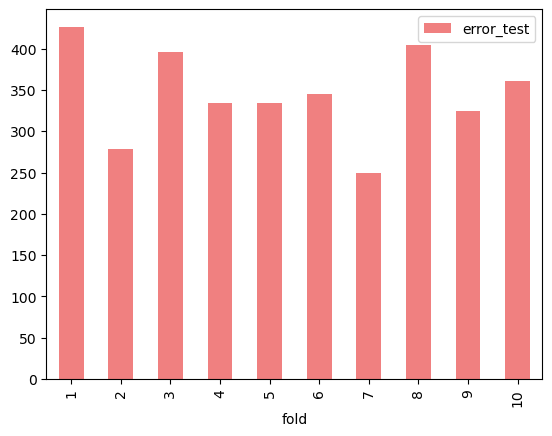

In [42]:
df_10.plot.bar(x='fold', y='error_test', color='lightcoral')

<Axes: xlabel='fold'>

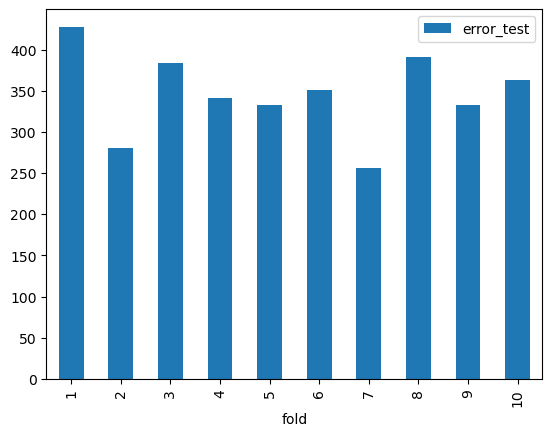

In [43]:
df_30.plot.bar(x='fold', y='error_test')

## Discusión de resultados y conclusiones

Se puede observar que para los diferentes modelos con 10 y 30 árboles, los errores de prueba (i.e. errores de generalización) son muy similares. Lo que nos lleva a hacer la hipótesis de que el número de árboles no mejorará al modelo.

Ahora se reentrenará el modelo con los mejores escenarios, i.e. donde ocurre el menor error de prueba

In [37]:
min_row_index = df_metricas['error_test'].idxmin()
min_row = df_metricas.loc[min_row_index]
t = min_row['num_arboles'].astype(int)
j = min_row['fold'].astype(int)
train = dataset_trabajo.where(col("fold") != j)
test = dataset_trabajo.where(col("fold") == j)
# Se ajusta el modelo a partir de los datos de entrenamiento
random_forest_reg = RandomForestRegressor(featuresCol = 'explicativas_final_vector',
                                          labelCol = variable_objetivo,
                                          numTrees = t)
modelo = random_forest_reg.fit(train)
# Se obtienen las estimaciones a partir de modelo tanto en los datasets de entrenamiento como de prueba
pred_train = modelo.transform(train)
pred_test = modelo.transform(test)
df_validacion = pred_test.select(variable_objetivo,'prediction','cluster').toPandas()
df_validacion['cluster'] = df_validacion['cluster'].astype(str)

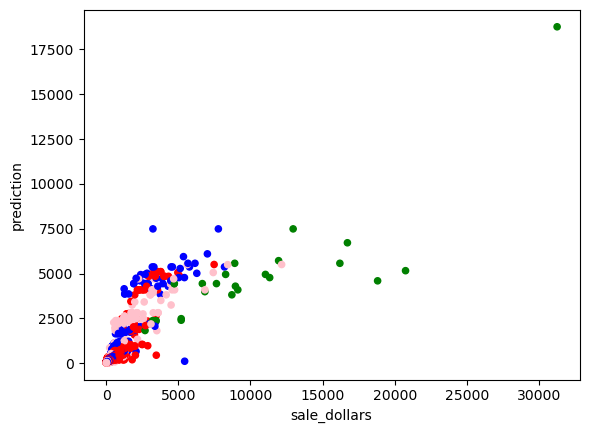

In [38]:
colors = {'0': 'red', '1': 'blue', '2': 'green', '3': 'pink'}
df_validacion.plot.scatter(x=variable_objetivo, y='prediction', c=df_validacion['cluster'].map(colors))
plt.show()

Se puede observar que modelo es bueno en estimar ventas menores a 15,000, pero falla en ventas que se consideran outliers (cluster de color verde)

Como el modelo no mejora al aumentar el número de árboles, se pueden hacer algunas conclusiones:

### 1. **El modelo ya ha alcanzado su límite de rendimiento**
   - Random Forest es un método de *ensamble* que promedia las predicciones de varios árboles para reducir la varianza.
   - Si agregar más árboles no mejora el modelo, es probable que ya se haya llegado a un punto donde el error de sesgo domina y la varianza ya no puede reducirse más.

### 2. **Los árboles adicionales son redundantes**
   - Random Forest usa *bagging* (muestreo con reemplazo) para generar diversidad entre los árboles.
   - Si los nuevos árboles son muy similares a los existentes (debido a datos poco informativos o características limitadas), no aportarán nueva información.

### 3. **El problema puede estar en los datos, no en el modelo**
   - **Falta de características relevantes**: Si las variables explicativas no tienen suficiente poder explicativo (valga la redundancia), más árboles no ayudarán.
   - **Ruido en los datos**: Si hay mucho error aleatorio en la variable objetivo, el modelo no podrá aprender patrones útiles.
   - **Datos insuficientes**: Si el conjunto de entrenamiento es muy pequeño, los árboles pueden estar sobreajustándose sin generalizar mejor.

### 4. **El modelo ya no sufre de overfitting**
   - Random Forest es robusto al overfitting en términos del número de árboles (a diferencia de, por ejemplo, Gradient Boosting).
   - Si el error de prueba ya no disminuye (pero tampoco aumenta), es señal de que el modelo generaliza bien y más árboles no empeorarán el resultado.

### ¿Qué hacer en estos casos?
- **Evaluar el error de entrenamiento vs. prueba**:
  - Si ambos son altos, significa alto sesgo (considerar más variables explicativas o un modelo más complejo).
  - Si el entrenamiento es bajo pero el de prueba alto, significa  que hay sobreajuste (regularizar más o reducir profundidad).
- **Probar otros modelos** (Gradient Boosting, redes neuronales, SVM) si Random Forest ya no mejora.
- **Realizar ingeniería de variables explicativas** para incluir variables más informativas.

### Conclusión:
Si aumentar el número de árboles en un Random Forest para regresión no mejora el modelo, lo más probable es que:
- **El modelo ya haya convergido** en su rendimiento máximo.
- **El problema esté en los datos** (calidad, cantidad o características).
- **Otras configuraciones del modelo** (como la profundidad de los árboles) sean más críticas que el número de árboles.

En estos casos, es mejor enfocarse en mejorar los datos o ajustar otros aspectos del modelo en lugar de seguir incrementando el número de árboles.